In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy
from scipy import stats,interpolate
from scipy.stats import skew,kurtosis,describe,variation,shapiro,levene,f_oneway
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import warnings 
warnings.filterwarnings(action='ignore')

import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn import model_selection
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,IsolationForest,StackingClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,classification_report,make_scorer,balanced_accuracy_score
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

from imblearn.over_sampling import SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks,CondensedNearestNeighbour,EditedNearestNeighbours

import random
import tensorflow 
import tensorflow as tf

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats

In [3]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3))

In [4]:
data = pd.read_csv('용해공정.csv')
data = data.drop(['Unnamed: 0','NUM'],axis=1)
data['STD_DT'] = pd.to_datetime(data['STD_DT'])
data = data.sort_values(by='STD_DT')
data = data.set_index(['STD_DT'])

In [5]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props #, NAlist

In [6]:
data = reduce_mem_usage(data)

Memory usage of properties dataframe is : 30.5859375  MB
******************************
Column:  MELT_TEMP
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  MOTORSPEED
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  MELT_WEIGHT
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  INSP
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  Target
dtype before:  int64
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  12.10693359375  MB
This is  39.583333333333336 % of the initial size


In [7]:
data

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Target
STD_DT,,,,,
2020-03-04 00:00:00,489,116,631,3.19,0
2020-03-04 00:00:00,433,78,609,3.19,0
2020-03-04 00:00:00,464,154,608,3.19,0
2020-03-04 00:00:00,379,212,606,3.19,0
2020-03-04 00:00:00,798,1736,604,3.21,0
...,...,...,...,...,...
2020-04-19 09:35:00,768,1725,668,3.21,0
2020-04-19 09:35:00,763,1747,8668,3.22,0
2020-04-19 09:35:00,381,208,669,3.18,0


In [8]:
#data_group = data.groupby('STD_DT')[data.drop(['Target'],axis=1).columns].mean()
#data_target = data.groupby('STD_DT')['Target'].agg(lambda x: x.mode()[0])

#data = pd.concat([data_group,data_target],axis=1)
#data = data.drop(['STD_DT'],axis=1)

In [9]:
Data = data
Target = 'Target'
Input_Data = data.drop(['Target'],axis=1)

#### 1. 통계분석

In [10]:
def Analysis(Data,Target,Input_Data):
    
    Stats = describex(Input_Data)
    
    print('Class Count','\n',Data[Target].value_counts(),'\n')
    print('Normal', round(Data[Target].value_counts()[0]/len(Data) * 100,2), '% of the dataset')
    print('Fault', round(Data[Target].value_counts()[1]/len(Data) * 100,2), '% of the dataset')
    print('Imbalanced Ratio(IR):',round(Data[Target].value_counts()[0]/Data[Target].value_counts()[1]*1,2),'%')
    
    sns.set(font_scale=1.0)
    plt.figure(figsize=(3.5,3))
    plt.grid(True)
    plt.title('Machine  \n (0: Normal || 1: Fault)', fontsize=11)
    colors = ["blue", "red"]
    sns.countplot(x= Target, data=Data,palette=colors)
    print('\n')
    
    for col in Data.columns:
        
        try : Data[col] = Data[col].astype('float')
        except: pass  
    
    fig, ax = plt.subplots(1,4, figsize=(20, 5)) # 데이터 개수에 따라 플롯 형태 변경 가능 
    fig.subplots_adjust(hspace = .4, wspace=.3, )
    ax = ax.ravel()

    for i in range(len(Input_Data.columns)):
        ax[i] = Input_Data.iloc[:,i].plot(kind='hist', ax=ax[i],color='blue',alpha=0.5,secondary_y=True,bins=5)
        plt.title(Input_Data.columns[i])
        
    print('\n')    
    df_fault = Data[Data[Target]==1]#.set_index('STD_DT')
    df_features = Data[Input_Data.columns] # set_index('STD_DT')

    ColumnNames = df_features.columns

    for feature in ColumnNames:
        sns.set_context('talk')
        _ = plt.figure(figsize=(50,10))
        _ = plt.plot(df_fault[feature], linestyle='none', marker='X', color='red', markersize=6)
        _ = plt.plot(df_features[feature], color='grey')
        _ = plt.title(feature)
        plt.show()    
        
    print('\n')    
    df_normal =  Data[Data[Target]==0][Input_Data.columns]
    df_fault = Data[Data[Target]==1][Input_Data.columns]
    
    Equal_VarTest = pd.DataFrame(stats.f_oneway(df_normal[Input_Data.columns],df_fault[Input_Data.columns])[1]).rename(columns={0:'Variance Equality F-Test '}).round(3)   
    Columns = pd.DataFrame(Data[Input_Data.columns].columns).rename(columns = {0:'Variables'})
    
    T_Statistic = pd.DataFrame(stats.ttest_ind(df_normal,df_fault,equal_var=True)[0].round(3)).rename(columns={0:'T-Statistic'})
    P_value = pd.DataFrame(stats.ttest_ind(df_normal,df_fault,equal_var=True)[1].round(3)).rename(columns={0:'P-Value'})
    df_significance = pd.concat([Columns,T_Statistic,P_value],axis=1) # 등분산성 가정 충족  
    
    T_Statistic = pd.DataFrame(stats.ttest_ind(df_normal,df_fault,equal_var=False)[0].round(3)).rename(columns={0:'T-Statistic-Welch'})
    P_value = pd.DataFrame(stats.ttest_ind(df_normal,df_fault,equal_var=False)[1].round(3)).rename(columns={0:'P-Value-Welch'})
    df_significance_Welch = pd.concat([T_Statistic,P_value],axis=1) # 등분산성 가정 위배 
    
    #print('\n')
    #plt.rcParams["figure.figsize"] = (125,100)
    #plt.title('Correlation Matrix',fontsize=25) 
    #sns.set(font_scale=1.0)
    #sns.heatmap(data = pd.concat([Data[Target],Input_Data],axis=1).corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='viridis_r')
    #plt.xticks(rotation=90) 
    
    df_corr = pd.concat([Data[Target],Input_Data],axis=1).corr().iloc[1:,0]
    df_corr = pd.DataFrame(df_corr).rename(columns={Target:'Corr'}).reset_index()['Corr']
    print('\n')
    
    X = Input_Data
    scaler = StandardScaler()
    scale_cols =  X.columns
    scaled_X = scaler.fit_transform(X[scale_cols])
    scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
    scaled_X = scaled_X.set_index(X.index)

    df_vif = pd.DataFrame()
    df_vif['VIF_Factor'] = [variance_inflation_factor(scaled_X.values, i) 
                         for i in range(scaled_X.shape[1])]
    
    Variable_Explain = pd.concat([df_significance,df_significance_Welch,Equal_VarTest,df_corr,df_vif],axis=1)
    
    print('Normality Test'.center(80))
    print('\n')
    
    for i in range(len(Input_Data.columns)):
        
        print(Input_Data.columns[i],stats.shapiro(Input_Data[Input_Data.columns[i]]),'\n')
        
    
    return  Stats, Variable_Explain #, LR_Coeff

Class Count 
 Target
0    491093
1    177067
Name: count, dtype: int64 

Normal 73.5 % of the dataset
Fault 26.5 % of the dataset
Imbalanced Ratio(IR): 2.77 %






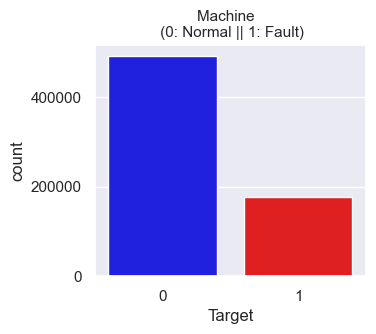

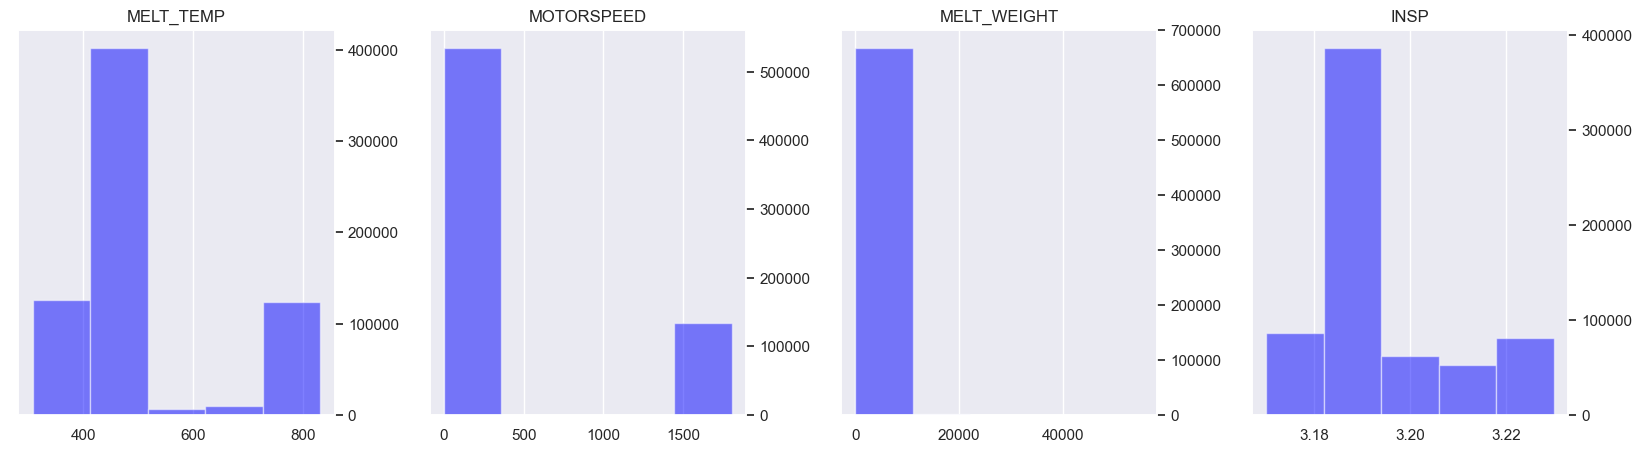

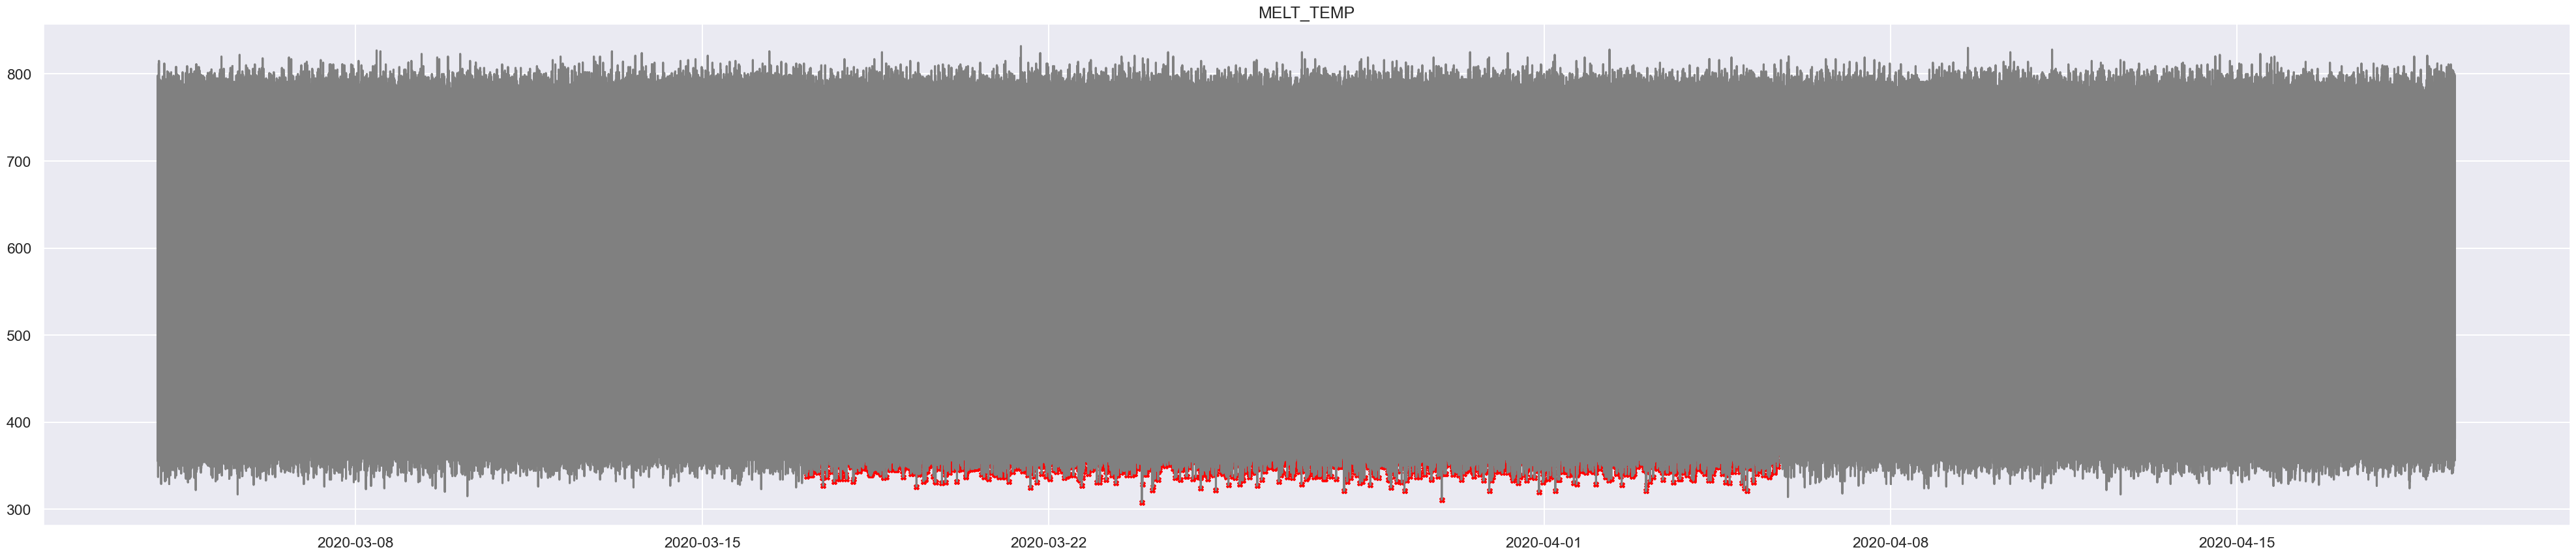

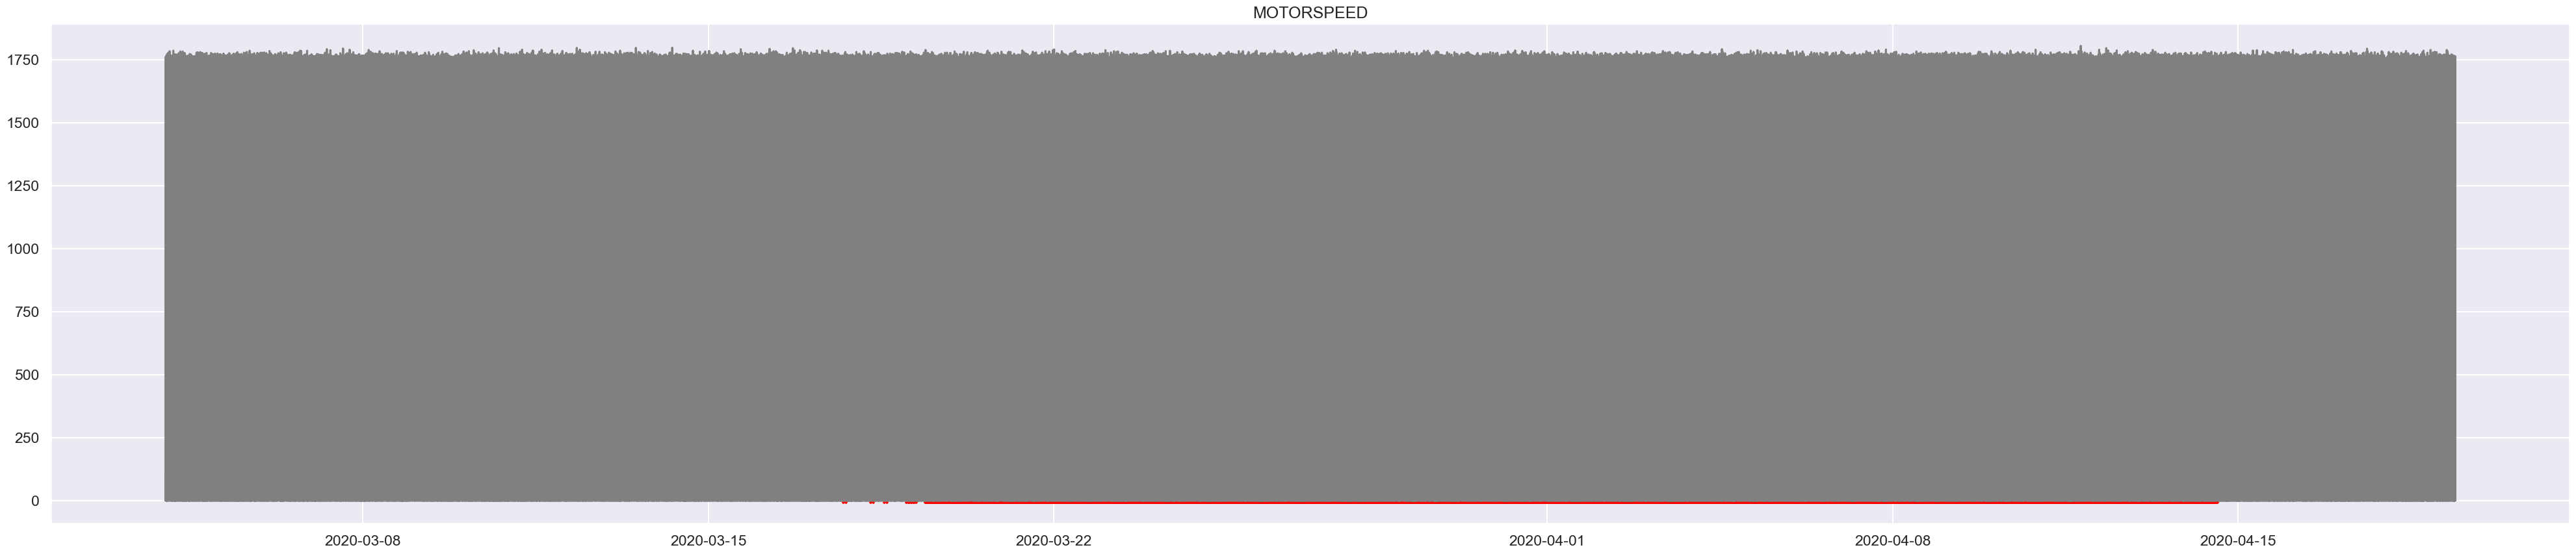

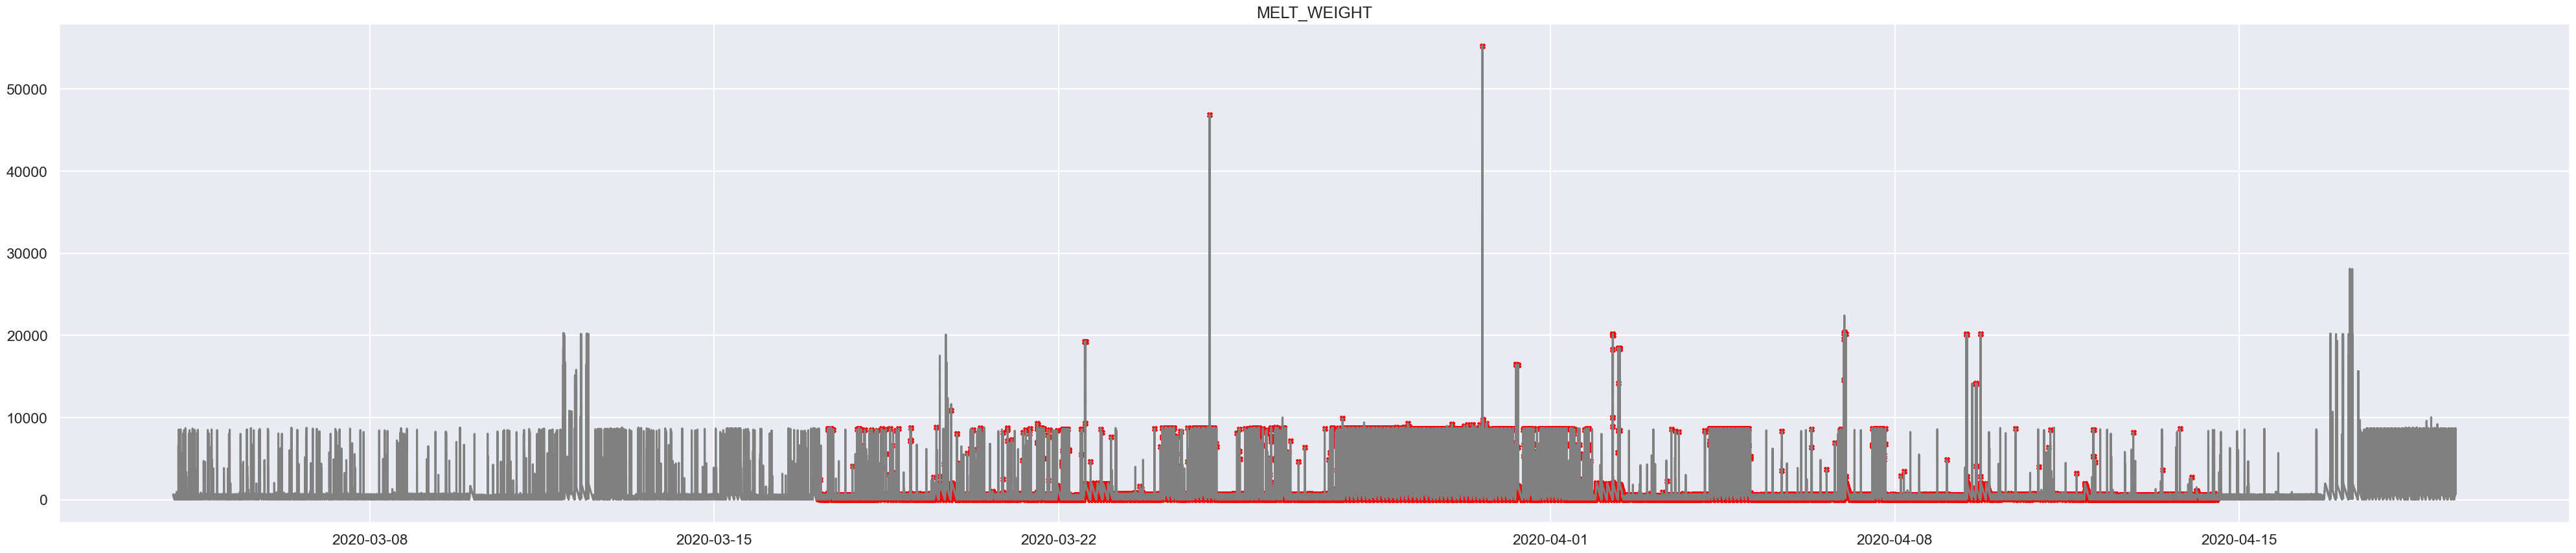

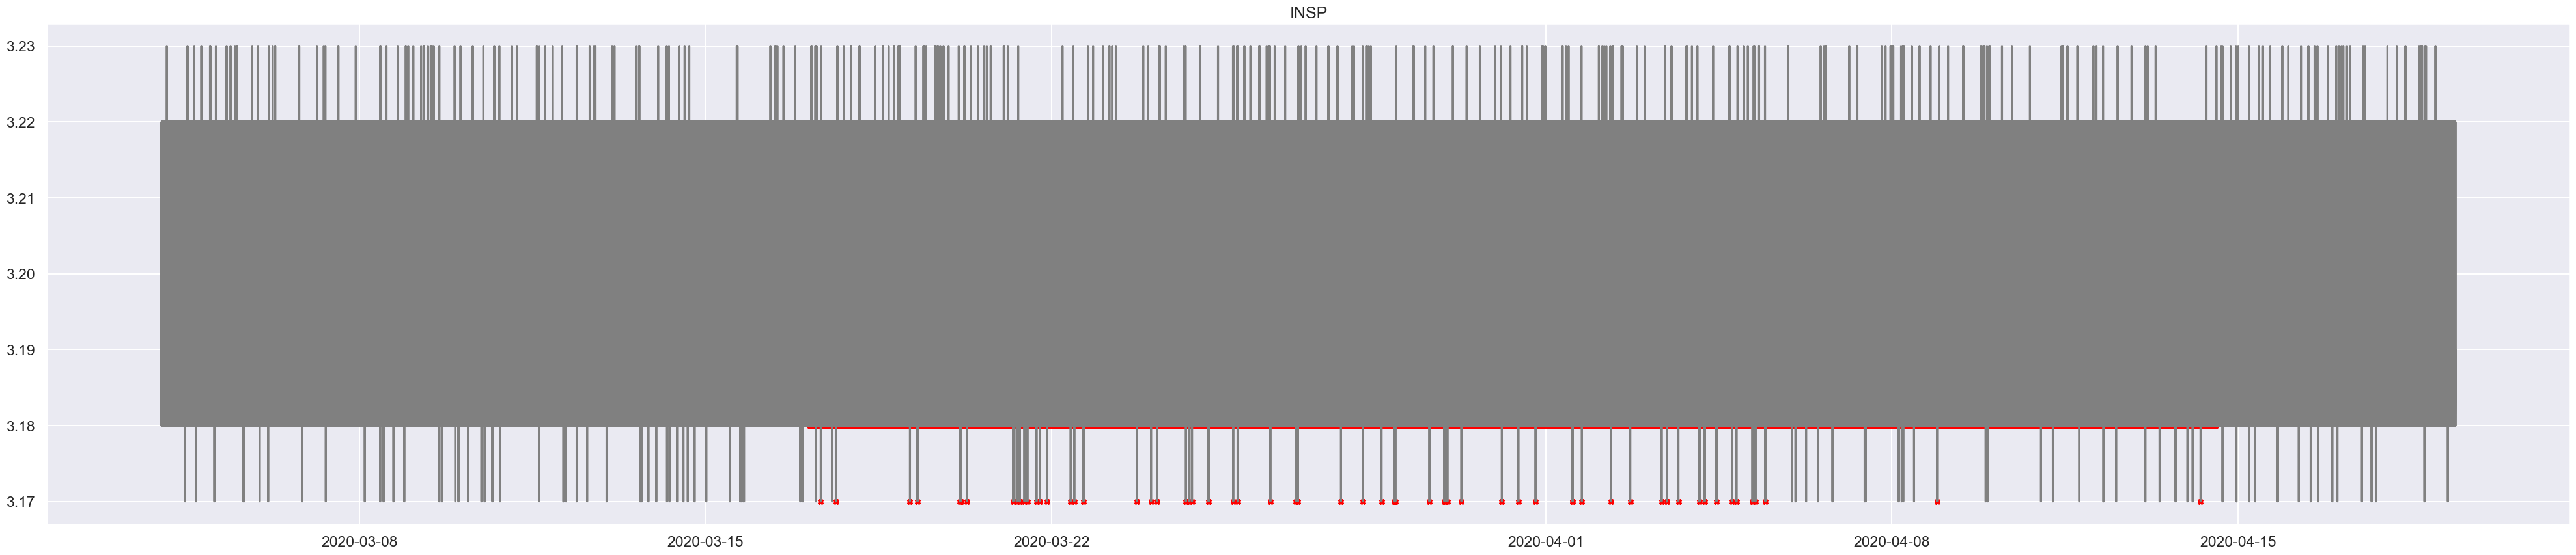





                                 Normality Test                                 


MELT_TEMP ShapiroResult(statistic=0.7682872414588928, pvalue=0.0) 

MOTORSPEED ShapiroResult(statistic=0.5703378319740295, pvalue=0.0) 

MELT_WEIGHT ShapiroResult(statistic=0.3060993552207947, pvalue=0.0) 

INSP ShapiroResult(statistic=0.7746243476867676, pvalue=0.0) 



In [11]:
Stats, Variable_Explain = Analysis(Data,Target,Input_Data)

In [12]:
Stats

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,668160.000000,668160.000000,668160.000000,668160.000000
mean,509.197599,459.796803,540.111877,3.194856
std,128.293299,639.426548,1108.158540,0.023279
min,308.000000,0.000000,0.000000,3.170000
25%,429.750000,119.000000,180.000000,3.190000
50%,469.000000,168.000000,372.000000,3.190000
75%,502.000000,218.000000,570.000000,3.200000
max,832.000000,1804.000000,55252.000000,3.230000
skewness,1.200629,1.475167,8.468632,1.050452
kurtosis,-0.043907,0.219541,103.102937,0.067746


In [13]:
Variable_Explain.head()

,Variables,T-Statistic,P-Value,T-Statistic-Welch,P-Value-Welch,Variance Equality F-Test,Corr,VIF_Factor
0,MELT_TEMP,314.902,0.0,486.036,0.0,0.0,-0.359490,12.679881
1,MOTORSPEED,263.145,0.0,433.490,0.0,0.0,-0.306438,9.607265
2,MELT_WEIGHT,-31.566,0.0,-29.271,0.0,0.0,0.038589,1.000005
3,INSP,271.961,0.0,385.511,0.0,0.0,-0.315697,6.414791


#### 2. 데이터 전처리 

In [14]:
Feature_Selection = True

In [15]:
def Train_Test_Split(Feature_Selection):
    
    Data = data
    Input_Data = data.drop(['Target'],axis=1)
    
    X = Input_Data
    y = Data['Target']
    
    if Feature_Selection == False:

        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.01,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.95,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test
    
    if Feature_Selection == True:
        
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.01,random_state=2021)
        Train = pd.concat([X_train,y_train],axis=1)
        Pass = Train[Train['Target']==0].drop(['Target'],axis=1)
        Fail = Train[Train['Target']==1].drop(['Target'],axis=1)

        T_Test = stats.ttest_ind(Pass,Fail,equal_var=True) # equal_var=True
        Columns = pd.DataFrame(X_train.columns).rename(columns={0:'Columns'})
        P_Value = pd.DataFrame(T_Test[1]).rename(columns={0:'P-Value'})
        Concat_columns_pvalues = pd.concat([Columns,P_Value],axis=1).dropna()

        Significant_Values = Concat_columns_pvalues[Concat_columns_pvalues['P-Value'] < 0.05]['Columns'].to_list()
        df_ttest = Data[Significant_Values]

        X_train,X_test,y_train,y_test = train_test_split(df_ttest,y,test_size=0.01,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.95,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test 
    
X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
X_train.shape, X_test.shape

((661478, 4), (3633, 4))

In [16]:
y_train.value_counts(),y_test.value_counts()

(Target
 0.0    486181
 1.0    175297
 Name: count, dtype: int64,
 Target
 0.0    1863
 1.0    1770
 Name: count, dtype: int64)

#### 3. ML 

In [17]:
# 활용할 ML 나열 
rf = RandomForestClassifier(random_state=2021)
rf_bal = RandomForestClassifier(random_state=2021,class_weight='balanced')
ada = AdaBoostClassifier(random_state=2021)
gbm = GradientBoostingClassifier(random_state=2021)
xgb = XGBClassifier(random_state=2021)
xgb_bal = XGBClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
lgbm =  LGBMClassifier(random_state=2021)
lgbm_bal = LGBMClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]) 

models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [18]:
def test_model(model):
        
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    
    Input_Resample = pd.concat([X_train,y_train],axis=1).sample(n=66000, random_state=2021).drop(['Target'],axis=1)
    Output_Resample = pd.concat([X_train,y_train],axis=1).sample(n=66000, random_state=2021)['Target']
    
    X_train = Input_Resample
    y_train =  Output_Resample
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    pred_proba = ml.predict_proba(X_test)[:,1]
    print('----------------------------------------------------------------------------------------------------------')
    get_clf_eval(y_test,pred,pred_proba)  
    print('\n')
    print(classification_report(y_test, pred,target_names=['양품','불량']))
    
    if model == rf:
        print('RandomForest Prediction Result')
        print('\n')
        
    elif model == rf_bal:
        print('RandomForest(Balanced Weight) Prediction Result')
        print('\n')  
        
    elif model == ada:
        print('AdaBoost Prediction Result')
        print('\n')
     
    elif model == gbm:
        print('GradientBoostingMachine Prediction Result')
        print('\n')
        
    elif model == xgb:
        print('XGBoost Prediction Result')
        print('\n')
        
    elif model == xgb_bal:
        print('XGBoost(Balanced Weight) Prediction Result')
        print('\n')    
        
    elif model == lgbm:
        print('LightGBM Prediction')
        print('\n')   
        
    elif model == lgbm_bal:
        print('LightGBM(Balanced Weight) Prediction Result')

In [19]:
test_model(models[5]) 

----------------------------------------------------------------------------------------------------------
Confusion Matrix
[[1279  584]
 [ 278 1492]]


정확도: 0.763 정밀도: 0.719 재현율: 0.843 AUC: 0.808 F1: 0.776 F2: 0.815 Balanced_Accuracy: 0.765


              precision    recall  f1-score   support

          양품       0.82      0.69      0.75      1863
          불량       0.72      0.84      0.78      1770

    accuracy                           0.76      3633
   macro avg       0.77      0.76      0.76      3633
weighted avg       0.77      0.76      0.76      3633

XGBoost(Balanced Weight) Prediction Result




In [20]:
test_model(models[7]) 

----------------------------------------------------------------------------------------------------------
Confusion Matrix
[[1245  618]
 [ 248 1522]]


정확도: 0.762 정밀도: 0.711 재현율: 0.86 AUC: 0.809 F1: 0.779 F2: 0.825 Balanced_Accuracy: 0.764


              precision    recall  f1-score   support

          양품       0.83      0.67      0.74      1863
          불량       0.71      0.86      0.78      1770

    accuracy                           0.76      3633
   macro avg       0.77      0.76      0.76      3633
weighted avg       0.77      0.76      0.76      3633

LightGBM(Balanced Weight) Prediction Result


In [21]:
#전체 모델  원큐 출력 
#for i in range(0,len(models)):

#    model = models[i]
#    test_model(model) 

#### 4. Oversampling & ML

In [22]:
def Oversampling_Test(model):
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    
    Input_Resample = pd.concat([X_train,y_train],axis=1).sample(n=66000, random_state=2021).drop(['Target'],axis=1)
    Output_Resample = pd.concat([X_train,y_train],axis=1).sample(n=66000, random_state=2021)['Target']
    
    X_train = Input_Resample
    y_train =  Output_Resample

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        oversampler = SMOTEENN(sampling_strategy=i,random_state=2021)
        X_train_over,y_train_over = oversampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_over,y_train_over) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   

        elif model == ada:
            print('AdaBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [23]:
#Oversampling_Test(models[0])

In [24]:
#Oversampling_Test(models[1])

In [25]:
#Oversampling_Test(models[2])

In [26]:
#Oversampling_Test(models[3])

In [27]:
Oversampling_Test(models[4])

Confusion Matrix
[[1361  502]
 [ 434 1336]]


정확도: 0.742 정밀도: 0.727 재현율: 0.755 AUC: 0.809 F1: 0.741 F2: 0.749 Balanced_Accuracy: 0.743


              precision    recall  f1-score   support

          양품       0.76      0.73      0.74      1863
          불량       0.73      0.75      0.74      1770

    accuracy                           0.74      3633
   macro avg       0.74      0.74      0.74      3633
weighted avg       0.74      0.74      0.74      3633

XGBoost SMOTEENN=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[1339  524]
 [ 390 1380]]


정확도: 0.748 정밀도: 0.725 재현율: 0.78 AUC: 0.808 F1: 0.751 F2: 0.768 Balanced_Accuracy: 0.749


              precision    recall  f1-score   support

          양품       0.77      0.72      0.75      1863
          불량       0.72      0.78      0.75      1770

    accuracy                           0.75      3633
   macro avg       0.75      0.75    

In [28]:
#Oversampling_Test(models[5])

In [29]:
Oversampling_Test(models[6])

Confusion Matrix
[[1317  546]
 [ 334 1436]]


정확도: 0.758 정밀도: 0.725 재현율: 0.811 AUC: 0.809 F1: 0.765 F2: 0.792 Balanced_Accuracy: 0.759


              precision    recall  f1-score   support

          양품       0.80      0.71      0.75      1863
          불량       0.72      0.81      0.77      1770

    accuracy                           0.76      3633
   macro avg       0.76      0.76      0.76      3633
weighted avg       0.76      0.76      0.76      3633

LightGBM SMOTEENN=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[1296  567]
 [ 313 1457]]


정확도: 0.758 정밀도: 0.72 재현율: 0.823 AUC: 0.81 F1: 0.768 F2: 0.8 Balanced_Accuracy: 0.759


              precision    recall  f1-score   support

          양품       0.81      0.70      0.75      1863
          불량       0.72      0.82      0.77      1770

    accuracy                           0.76      3633
   macro avg       0.76      0.76      

In [30]:
#Oversampling_Test(models[7])

#### 5. Undersampling & ML

In [31]:
def Undersampling_Test(model):
     
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    
    Input_Resample = pd.concat([X_train,y_train],axis=1).sample(n=66000, random_state=2021).drop(['Target'],axis=1)
    Output_Resample = pd.concat([X_train,y_train],axis=1).sample(n=66000, random_state=2021)['Target']
    
    X_train = Input_Resample
    y_train =  Output_Resample

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        undersampler = RandomUnderSampler(sampling_strategy=i,random_state=2021) 
        #undersampler = NearMiss() --> ROS 이외의 언더샘플링 진행시 for 반복문 해제 
        # TomekLink(), NearMiss, EditedNearestNeigbours,CondensedNearestNeighbour
        
        X_train_under,y_train_under = undersampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_under,y_train_under) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    

        elif model == ada:
            print('AdaBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [32]:
#Undersampling_Test(models[0])

In [33]:
#Undersampling_Test(models[1])

In [34]:
#Undersampling_Test(models[2])

In [35]:
#Undersampling_Test(models[3])

In [36]:
#Undersampling_Test(models[4])

In [37]:
#Undersampling_Test(models[5])

In [38]:
Undersampling_Test(models[6])

Confusion Matrix
[[1296  567]
 [ 317 1453]]


정확도: 0.757 정밀도: 0.719 재현율: 0.821 AUC: 0.809 F1: 0.767 F2: 0.798 Balanced_Accuracy: 0.758


              precision    recall  f1-score   support

          양품       0.80      0.70      0.75      1863
          불량       0.72      0.82      0.77      1770

    accuracy                           0.76      3633
   macro avg       0.76      0.76      0.76      3633
weighted avg       0.76      0.76      0.76      3633

LightGBM ROS=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[1278  585]
 [ 300 1470]]


정확도: 0.756 정밀도: 0.715 재현율: 0.831 AUC: 0.807 F1: 0.769 F2: 0.805 Balanced_Accuracy: 0.758


              precision    recall  f1-score   support

          양품       0.81      0.69      0.74      1863
          불량       0.72      0.83      0.77      1770

    accuracy                           0.76      3633
   macro avg       0.76      0.76      0

In [39]:
#Undersampling_Test(models[7])

#### 6. AutoEncoder

In [41]:
def preprocessing():
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    
    Input_Resample = pd.concat([X_train,y_train],axis=1).sample(n=66000, random_state=2021).drop(['Target'],axis=1)
    Output_Resample = pd.concat([X_train,y_train],axis=1).sample(n=66000, random_state=2021)['Target']
    
    X_train = Input_Resample
    y_train =  Output_Resample
    
    Train_All = pd.concat([X_train,y_train],axis=1)
    X_train_Normal = Train_All[Train_All['Target']==0].drop(['Target'],axis=1)

    scaler = MinMaxScaler()
    scaler.fit(X_train_Normal) # Train Data 기준으로 Train/Test 스케일링 진행 

    X_train_Normal = pd.DataFrame(scaler.transform(X_train_Normal),columns = X_train_Normal.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
    
    return X_train_Normal, X_test , y_train ,y_test

X_train_Normal, X_test , y_train ,y_test = preprocessing()

In [42]:
X_train_Normal.shape, X_test.shape

((48492, 4), (3633, 4))

In [43]:
y_train.value_counts(),y_test.value_counts()

(Target
 0.0    48492
 1.0    17508
 Name: count, dtype: int64,
 Target
 0.0    1863
 1.0    1770
 Name: count, dtype: int64)

In [44]:
def build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio):
    
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    
    input_layer = Input(shape = (X.shape[1],))
    
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    
    encoded = Dense(latent_vector, activation = function)(encoded) 
    
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [45]:
def train_autoencoder(model,X,batch,epoch,val,patience):
    history = model.fit(X, X,
                              batch_size = batch, epochs = epoch, 
                              validation_split = val,callbacks=EarlyStopping(patience=patience))
    
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()

    return history 

In [46]:
X = X_train_Normal

outer = 128
inner = 64
latent_vector = 32
dropout_ratio = 0.2
function = 'tanh'

batch = 250
epoch = 1000
val = 0.2
patience = 10

Epoch 1/1000
156/156 [==============================] - 2s 4ms/step - loss: 0.0239 - val_loss: 0.0036
Epoch 2/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 3/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 4/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/1000
156/156 [==============================] - 0s 3ms/step - loss: 0.001

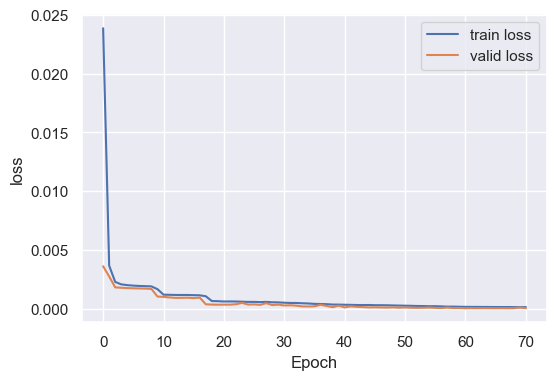

In [47]:
autoencoder = build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio)

history = train_autoencoder(autoencoder,X,batch,epoch,val,patience)

In [48]:
def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss, bins=40,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss, bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    #anomalies = threshold_test > threshold_train
    #print('\n')
    #print("Train Threshold Based Detected Anomalies: ", np.sum(anomalies))
    #print("Real Normal Labels from Test Data : ", y_test.value_counts()[0])
    #print("Real Fault Labels from Test Data : ", y_test.value_counts()[1])
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

114/114 [==============================] - 0s 835us/step




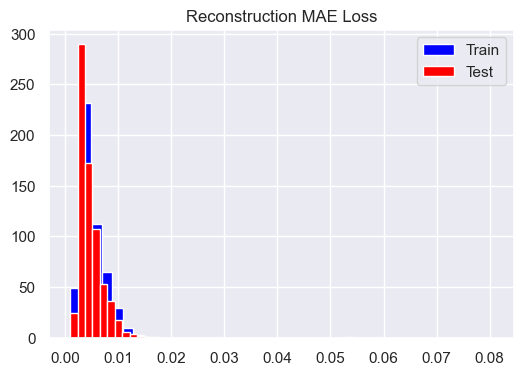



Train (Normal Only) Reconstruction error threshold: 0.08053339733556411


Test Reconstruction error threshold: 0.05698752502356521


In [49]:
train_mae_loss, test_mae_loss, threshold_train, threshold_test = reconstruction_loss(autoencoder,X_train_Normal,X_test)

In [50]:
def anomaly_threshold(threshold,model):
    test_score_df = pd.DataFrame(X_test[:])
    test_score_df['loss'] = test_mae_loss # --> pred_proba
    test_score_df['threshold'] = threshold # 레이블 예측 임계값 
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    get_clf_eval(y_test,test_score_df['score'],test_score_df['loss'])
    print('\n')
    print(classification_report(y_test, test_score_df['score'],target_names=['양품','불량']))
    
    test_error = pd.DataFrame({'Reconstruction_error': test_mae_loss,'True_class': y_test.reset_index()['Target']})

    plt.figure(figsize=(4, 3))
    plt.title(model, fontsize=12)
    plt.scatter(test_error.index[test_error['True_class'] == 0],test_error[test_error['True_class'] == 0]['Reconstruction_error'], s = 10, label = 'Normal')
    plt.scatter(test_error.index[test_error['True_class'] == 1],test_error[test_error['True_class'] == 1]['Reconstruction_error'], s = 10, label = 'Fault')
    plt.xlabel('Count', fontsize=10)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=10)
    plt.axhline(threshold,color = 'red', ls = '--', label = 'Threshold = %0.2f' % (threshold))
    plt.legend(bbox_to_anchor=(1.0, 1.03))
    plt.show()

In [51]:
threshold_train

0.08053339733556411

Confusion Matrix
[[ 249 1614]
 [ 391 1379]]


정확도: 0.448 정밀도: 0.461 재현율: 0.779 AUC: 0.387 F1: 0.579 F2: 0.685 Balanced_Accuracy: 0.456


              precision    recall  f1-score   support

          양품       0.39      0.13      0.20      1863
          불량       0.46      0.78      0.58      1770

    accuracy                           0.45      3633
   macro avg       0.42      0.46      0.39      3633
weighted avg       0.42      0.45      0.38      3633



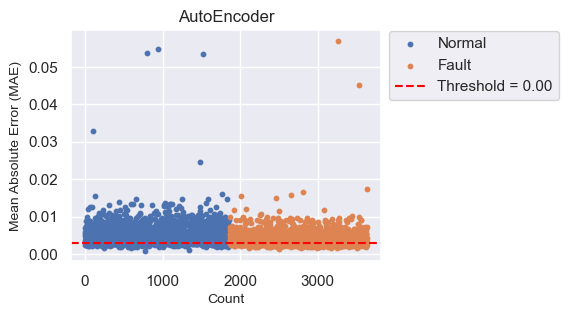

In [54]:
anomaly_threshold(threshold = 0.003, model='AutoEncoder')

In [ ]:
#for i in range(0,len(test_mae_loss)):
    
    
#    anomaly_threshold(test_mae_loss[i],'Autoencoder')
#    print('threshold'+ ' = ' + str(test_mae_loss[i]))
#    print('-----------------------------------------------------------------------------------------')
#    print('\n')